<center>
<a href="https://websites.isae-supaero.fr/certificat/" ><img src="https://websites.isae-supaero.fr/IMG/gif/computer-science.gif" style="float:left; max-width: 120px; display: inline" alt="Toulouse Tech"/> </a>

<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:right; max-width: 120px; display: inline" alt="INSA"/></a> 

<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" style="max-width: 250px; display: inline"  alt="Wikistat"/></a>

</center>

# [Certificat Science des Données](https://github.com/Certificat-sciences-des-donnees-bigdata) [Module de Sensibilisation](https://github.com/Certificat-sciences-des-donnees-bigdata/Module-sensibilisation)

## [Introduction à l'Apprentissage Statistique]()

##  Exemple "Jouet": Discrimination de [`blobs`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) 

**Résumé**: Les méthodes de [discrimination](http://wikistat.fr/pdf/st-m-app-intro.pdf) sont  comparées sur un jeu de données fictif obtenu par la commande `make_blobs` de Scikit-learn. L'objectif est de mettre en évidence le rôle des paramètres de complexité de différentes méthodes (régression logistique, k-nn, réseaux de neurones, arbre de décision, bagging, svm) et de comparer les formes spécifiques des frontières estimées par chacune d'elle. Cela permet d'illustrer les principales méthodes d'apprentissage de [*Scikit-learn*](http://scikit-learn.org/stable/)

## 1 Introduction
Les données se présentent sous la forme de nuages de points dans $R^2$ plus présentant des groupes plus ou moins distincts ou mélangés. L'objectif est d'apprendre ces données très particulières afin de discriminer les deux classes. Les données étant simplement dans $R^2$, il est facile de prévoir la classe de chaque point du plan et ainsi de visualiser la frontière entre les prévisions des deux classes. L'intérêt est de représenter ainsi facilement le rôle jouer par les paramètres de complexité de chaque méthode et de comparer les formes des frontières obtenues et donc la plus ou moins bonne adéquation d'une méthode à la spécificité de ces données simulées. 

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
# option d'impression
import numpy as np
np.set_printoptions(precision=3)

## 2 Génération des données
Génération aléatoire de 20 groupes de nuages de 1000 points dans R2. Le générateur de nombres aléatoires est initialisés par souci de reproductibilité. Les points sont séparés en deux classes. 

In [2]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=1000, centers=20, random_state=123)
labels = ["b", "r"]
y = np.take(labels, (y < 10))
print(X)
print(y[:5])

[[-6.453 -8.764]
 [ 0.29   0.147]
 [-5.184 -1.253]
 ...
 [-0.231 -1.608]
 [-0.603  6.873]
 [ 2.284  4.874]]
['r' 'r' 'b' 'r' 'b']


Représentation des données dans le plan.

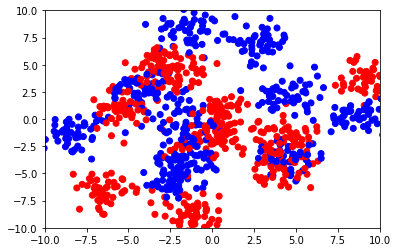

In [3]:
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.show()

## 3 Les *classifieurs* de Scikit-learn

Tous les algorithmes et méthodes de Scikit-learn se présentent sous la forme d'une combinaison de 3 "interfaces":
* estimation pour ajuster des modèles,
* prévision pour de nouvelles observations,
* transformation pour convertir des données.

Celles-ci peuvent être facilement combinées et enchaînées en un *pipeline*.

La fonction définie ci-dessous prévoit chaque point d'une grille du plan et trace un graphe de contour des probabilités. Elle permet indirectment une représentation des frontières construites par un classifieur.

In [4]:
def plot_surface(clf, X, y, xlim=(-10, 10), ylim=(-10, 10), n_steps=250):
    fig = plt.figure()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], n_steps), np.linspace(ylim[0], ylim[1], n_steps))
    if hasattr(clf, "decision_function"):
        z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]      
    z = z.reshape(xx.shape)
    plt.contourf(xx, yy, z, alpha=0.8, cmap=plt.cm.RdBu_r)
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    plt.show()

### 3.1 [Régression logistique](http://wikistat.fr/pdf/st-m-app-rlogit.pdf)
Exemple d'utilisation de la régression logistique pour discriminer les bleus des rouges.

In [25]:
# Importation de la fonction
from sklearn.linear_model import LogisticRegression
logitReg = LogisticRegression()
# Les options par défaut de l'algorithme
logitReg.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

#### Prévision
Prévision de la classe des 5 premiers points

In [7]:
print(logitReg.predict(X[:5])) 

['r' 'b' 'r' 'b' 'r']


Ou de la probabilité des classes.

In [8]:
print(logitReg.predict_proba(X[:5]))

[[0.346 0.654]
 [0.505 0.495]
 [0.483 0.517]
 [0.576 0.424]
 [0.444 0.556]]


La fonction ci-dessous trace la frontière entre les deux classes avec d'un côté la zone rouge la plus probable *vs.* la zone bleue.

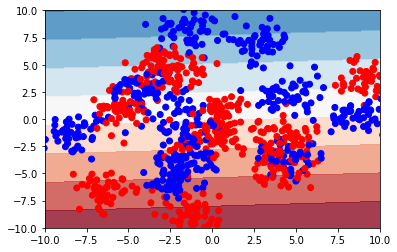

In [9]:
plot_surface(logitReg, X, y)

**Q** Que dire de la pertinence d'une frontière produite par la régression logistique quadratique.

### 3.1 [*k* plus proches voisins](http://wikistat.fr/pdf/st-m-app-add.pdf)
#### Estimation

In [10]:
# Importation de la fonction
from sklearn.neighbors import KNeighborsClassifier  
# Détermination des paramètres et définition de l'estimateur
knnF = KNeighborsClassifier(n_neighbors=5)

# Apprentissage ou estimation du modèle sur l'échantillon d'apprentissage 
# mais il ne se passe rien  dans le cas de *k*-nn avant en dehors de la phase de prévision. 
knnF.fit(X, y)
# Les options de cet algorithmes:

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

#### Prévision
Prévision de la classe des 5 premiers points

In [11]:
print(knnF.predict(X[:5])) 

['r' 'r' 'r' 'b' 'b']


Ou de la probabilité des classes.

In [12]:
print(knnF.predict_proba(X[:5]))

[[0.  1. ]
 [0.  1. ]
 [0.2 0.8]
 [0.6 0.4]
 [0.8 0.2]]


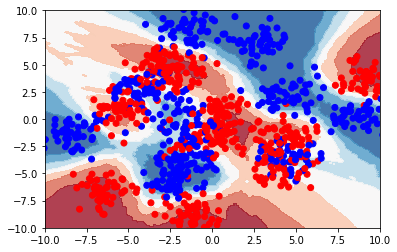

In [13]:
knnF = KNeighborsClassifier(n_neighbors=50)
knnF.fit(X, y)
plot_surface(knnF, X, y)

Ce qui donne une bonne idée de  la forme des frontières estimées entre les classes.

Faire varier le paramère `n_neighbors` (1 à 500) et observer l'impact sur la forme des classes.

# <FONT COLOR="Red">Compléments: Méthodes d'Apprentissage </font> pour le [Module d'Immersion](https://github.com/Certificat-sciences-des-donnees-bigdata/Module-immersion)

### 3.2 [Arbre binaire de décision](http://wikistat.fr/pdf/st-m-app-cart.pdf)

Les frontières sont construites à partir de parallèles aux axes. Faire varier la profondeur maximale `max_depth` de l'arbre.

In [ ]:
from sklearn.tree import DecisionTreeClassifier 
treeF = DecisionTreeClassifier(max_depth=2)
treeF.fit(X, y)
plot_surface(treeF, X, y)

### 3.3 [Forêts aléatoires](http://wikistat.fr/pdf/st-m-app-agreg.pdf) 
Obtenues par agrégation d'arbres, une forêt arrondit les frontières. Avec seulement 2 variables (dans R2), cela revient à faire du *bagging*. Faire variaer le nombre d'arbres: `n_estimators` (1 à 20), de la forêt. 

In [ ]:
from sklearn.ensemble import RandomForestClassifier 
rfF = RandomForestClassifier(n_estimators=2)
rfF.fit(X, y)
plot_surface(rfF, X, y)

### 3.4 Séparateur à Vaste Marge ([SVM](http://wikistat.fr/pdf/st-m-app-svm.pdf))
SVM linéaire, pas très intéressant sur ces données, puis gaussien. Faire varier la pénalisation `C` et l'étendue du noyau gaussien.

In [ ]:
# Noyau linéaire
from sklearn.svm import SVC
svmF = SVC(kernel="linear",C=1)  # try kernel="rbf" instead
svmF.fit(X, y)
plot_surface(svmF, X, y)

Faire varier C de 10-5 à 10^5, gamma de 0.001 à 100

In [ ]:
# Noyau gaussien avec valeurs par défaut de C et gamma
from sklearn.svm import SVC
svmF = SVC(kernel="rbf", C=1, gamma='auto')  
svmF.fit(X, y)
plot_surface(svmF, X, y)

### 3.5 [Perceptron multicouches](http://wikistat.fr/pdf/st-m-app-rn.pdf)
Faire varier le nombre de couches cachées, le nombe de neurones sur ces couches, la pénalisation *l2* `alpha`. 

In [ ]:
# Trois couches de 100 neurones avec alpha par défaut
from sklearn.neural_network import MLPClassifier
nnetF = MLPClassifier(hidden_layer_sizes=(100, 100, 100),alpha=0.0001)
nnetF.fit(X, y)
plot_surface(nnetF, X, y)

### 3.6 Processus gaussien
Consulter la [doc](http://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessClassifier.html) en ligne. 

In [ ]:
from sklearn.gaussian_process import GaussianProcessClassifier
pgF = GaussianProcessClassifier()
pgF.fit(X, y)
plot_surface(pgF, X, y)         

#### Conclusion: 
**Q** Quelles sont les méthodes ou modèles les plus adaptés à ces données? Est-ce généralisable à d'autres?